In [1]:
import os, sys, urllib, gzip
sys.path.append('/home/rui/pylearn2')
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy

import pylearn2

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, CuDNN 3007)
/home/rui/.pyenv/versions/3.5.0/envs/cae/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [14]:
from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
from lasagne.regularization import regularize_layer_params, l2, l1
import theano
import theano.tensor as T
import time
import lasagne

In [3]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print('Using lasagne.layers (slower)')

Using cuda_convnet (faster)


In [4]:
f = gzip.open('/home/rui/Downloads/mnist.pkl.gz', 'rb')
try:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set = pickle.load(f)
f.close()
X, y = train_set

In [5]:
X = np.reshape(X, (-1, 1, 28, 28))
print('X type and shape:', X.dtype, X.shape)
print('X.min():', X.min())
print('X.max():', X.max())

X type and shape: float32 (50000, 1, 28, 28)
X.min(): 0.0
X.max(): 0.996094


In [6]:
X_out = X.reshape((X.shape[0], -1))
print('X_out:', X_out.dtype, X_out.shape)

X_out: float32 (50000, 784)


In [7]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 16
dense_mid_size = 128
pad_in = 'valid'
pad_out = 'full'

In [50]:
def build_cnn(input_var=None):
    
    network = InputLayer(shape=(None,  X.shape[1], X.shape[2], X.shape[3]),input_var=input_var)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0), filter_size=filter_size, pad=pad_in)

    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0), filter_size=filter_size, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)

    network = Conv2DLayerFast(network, num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0), filter_size=filter_size, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)
    
    network = ReshapeLayer(network, shape =(([0], -1)))
    
    network = DenseLayer(network, num_units= dense_mid_size, W=lasagne.init.Orthogonal(1.0))
    
    encode_layer = DenseLayer(network, name= 'encode', num_units= encode_size, W=lasagne.init.Orthogonal(1.0))

    network = DenseLayer(encode_layer, num_units= dense_mid_size, W=lasagne.init.Orthogonal(1.0))
    
    network = DenseLayer(network, num_units= 800, W=lasagne.init.Orthogonal(1.0))
    
    network = ReshapeLayer(network, shape =(([0], 2*conv_num_filters, 5, 5)))
    
    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0), filter_size=filter_size, pad=pad_out)

    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerSlow(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0), filter_size=filter_size, pad=pad_out)

    network = Conv2DLayerSlow(network, num_filters=1, W=lasagne.init.Orthogonal(1.0), filter_size=filter_size, pad=pad_out)
    
    network = ReshapeLayer(network, shape =(([0], -1)))

    return network, encode_layer

In [10]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [51]:
num_epochs = 30
input_var = T.tensor4('inputs')
target_var = T.matrix('targets')
learnrate=0.01
# Create neural network model (depending on first command line parameter)
print("Building model and compiling functions...")
network, encode_layer = build_cnn(input_var)
l2_penalty = regularize_layer_params(network, l2)
l1_penalty = regularize_layer_params(network, l1)
reconstructed = lasagne.layers.get_output(network)
loss = lasagne.objectives.squared_error(reconstructed, target_var)
loss = loss.mean()+0.005*l2_penalty+0.005*l1_penalty

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=learnrate, momentum=0.9)
train_fn = theano.function([input_var, target_var], loss, updates=updates)
print("Starting training...")


for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    if epoch % 5 == 4:
        learnrate*=0.9
    updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=learnrate, momentum=0.9)
    for batch in iterate_minibatches(X, X_out, 500, shuffle=False):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))

    # Optionally, you could now dump the network weights to a file like this:
np.savez('CAE_MNIST.npz', *lasagne.layers.get_all_param_values(network))

Building model and compiling functions...
Starting training...
Epoch 1 of 30 took 14.327s
  training loss:		0.088268
Epoch 2 of 30 took 14.617s
  training loss:		0.070305
Epoch 3 of 30 took 14.899s
  training loss:		0.063422
Epoch 4 of 30 took 14.262s
  training loss:		0.061299
Epoch 5 of 30 took 14.158s
  training loss:		0.058538
Epoch 6 of 30 took 14.195s
  training loss:		0.054553
Epoch 7 of 30 took 14.164s
  training loss:		0.050724
Epoch 8 of 30 took 14.169s
  training loss:		0.047808
Epoch 9 of 30 took 14.216s
  training loss:		0.045372
Epoch 10 of 30 took 14.176s
  training loss:		0.042989
Epoch 11 of 30 took 14.516s
  training loss:		0.040943
Epoch 12 of 30 took 14.186s
  training loss:		0.039267
Epoch 13 of 30 took 14.194s
  training loss:		0.037841
Epoch 14 of 30 took 14.176s
  training loss:		0.036597
Epoch 15 of 30 took 14.176s
  training loss:		0.035500
Epoch 16 of 30 took 14.223s
  training loss:		0.034569
Epoch 17 of 30 took 14.182s
  training loss:		0.033801
Epoch 18 of

In [19]:
os.getcwd()

'/home/rui/CNN'

In [52]:
 X_pred, X_encode = lasagne.layers.get_output([network, encode_layer])

In [61]:
CAE_predict = theano.function([input_var], [lasagne.layers.get_output(network),lasagne.layers.get_output(network)])
X_pred, X_encode = CAE_predict(X[0:200,:,:,:])


In [62]:
X_pred = X_pred.reshape(-1,28,28)

2


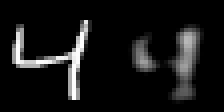

In [39]:
def get_picture_array(X, rescale=4):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images(index):
    print(index)
    original_image = Image.fromarray(get_picture_array(255 * X[index]))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(255 * X_pred[index]))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('test.png', format="PNG")
    return IPImage('test.png')

188


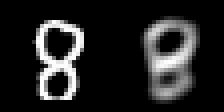

In [70]:
compare_images(188)

In [78]:
for i in lasagne.layers.get_all_layers(network):
    if i.name == 'encode':
        print(i)

In [79]:
encode_layer.input_layer